# RNN Sequence Classifier Training

This notebook trains an RNN-based sequence classifier for conformance checking. The model learns to predict whether an event sequence conforms to expected process behavior.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import random
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

## Load Event Log Data

Load the enriched event log from the RTFMP dataset that contains conformance checking results.

In [2]:

data = pd.read_csv(os.path.join("..", "eventlogs", "rtfmp", "final_enriched_event_log.csv")) # Load the log enriched with explained conformance checking
data["timestamp"] = pd.to_datetime(data["time:timestamp"])

## Prepare Sequences and Labels

Transform the event log into sequences of activity names with binary labels:
- Label 1: conformant (no conformance violations)
- Label 0: non-conformant (has violations)

In [28]:
dt = []

for case, g in data.groupby("case:concept:name"):
    label = 1 if g["conformance_result"].isna().iloc[0] else 0 # Add conformance label based on if violations present

    sequence = (
        g.sort_values("timestamp")["concept:name"]
        .tolist()
    )

    dt.append((sequence, label)) # add the trace with a label to the train data 

dt[0], dt[5], dt[10]



((['Create Fine', 'Payment', 'Payment', 'Payment', 'Payment'], 1),
 (['Create Fine', 'Send Fine', 'Payment'], 1),
 (['Create Fine'], 0))

### Train/Test Split - 80/20 



In [32]:
def train_test_split_stratified(data, test_size=0.2, random_seed=42):
    """
    Create stratified train/test split from sequence data.
    
    Args:
        data: List of (sequence, label) tuples
        test_size: Proportion of data to use for testing
        random_seed: Random seed for reproducibility
        
    Returns:
        dt_train, dt_test, seq_test, cat_test
    """
    random.seed(random_seed)
    
    # Convert to tuples for deduplication, then back to lists
    dt_unique = list({(tuple(seq), label) for seq, label in data})
    dt_unique = [(list(seq), label) for seq, label in dt_unique]
    
    dt_conf = [x for x in dt_unique if x[1] == 1]
    dt_nonconf = [x for x in dt_unique if x[1] == 0]
    
    n_conf_train = int((1 - test_size) * len(dt_conf))
    n_nonconf_train = int((1 - test_size) * len(dt_nonconf))
    
    dt_conf_train = random.sample(dt_conf, n_conf_train)
    dt_nonconf_train = random.sample(dt_nonconf, n_nonconf_train)
    
    dt_train = dt_conf_train + dt_nonconf_train
    
    # Test set = all unique sequences not selected for training
    train_set = {(tuple(seq), label) for seq, label in dt_train}
    dt_test = [(seq, label) for seq, label in dt_unique if (tuple(seq), label) not in train_set]
    
    seq_test = [seq for seq, label in dt_test]
    cat_test = [label for seq, label in dt_test]
    
    print(f"Train size: {len(dt_train)}")
    print(f"Test size: {len(dt_test)}")
    print(f"Train class balance: {sum(l == 1 for _, l in dt_train)} conformant, {sum(l == 0 for _, l in dt_train)} non-conformant")
    print(f"Test class balance: {sum(l == 1 for _, l in dt_test)} conformant, {sum(l == 0 for _, l in dt_test)} non-conformant")
    return dt_train, dt_test, seq_test, cat_test, dt_unique

dt_train, dt_test, seq_test, cat_test, dt_unique = train_test_split_stratified(dt)

Train size: 106
Test size: 28
Train class balance: 52 conformant, 54 non-conformant
Test class balance: 14 conformant, 14 non-conformant


## Build Vocabulary

Create a mapping from activity names to integer IDs. The vocabulary includes all unique activities plus a special `<pad>` token (ID=0) for padding sequences.

In [33]:
data = [
    (["A","B","C"], 1),
    (["A","A","C"], 0),
    (["B","C","D"], 1),
    (["A","C"], 0),
    (["C","D","E","F"], 1),
    (["A","B","B"], 0),
]

In [35]:
all_events = sorted({e for seq,_ in dt_unique for e in seq})
event2id = {e:i+1 for i,e in enumerate(all_events)}  # Ids from 1
event2id["<pad>"] = 0
id2event = {i:e for e,i in event2id.items()}

vocab_size = len(event2id)

vocab_size

13

## Padding Function

Define a collate function to pad sequences in a batch to the same length. This is required for efficient batch processing in PyTorch.

In [ ]:
def pad_batch(batch):
    """Pad a batch of (sequence, label) pairs to a uniform length.

    Converts event sequences to ID tensors, pads them with 0s up to the
    maximum sequence length in the batch, and returns the padded tensor,
    original lengths, and labels.

    """
    # Convert sequences to id tensors and collect labels
    sequences = [torch.tensor([event2id[e] for e in seq]) for seq,_ in batch]
    labels = torch.tensor([label for _,label in batch])

    lengths = torch.tensor([len(seq) for seq in sequences])
    max_len = max(lengths)

    padded = torch.zeros(len(sequences), max_len, dtype=torch.long)
    for i, seq in enumerate(sequences):
        padded[i, :len(seq)] = seq  # pad with zeros up to max length

    return padded, lengths, labels

## Create Dataset and DataLoader

Set up PyTorch Dataset and DataLoader for batch training with shuffling.

In [37]:
class SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = SeqDataset(dt_train)
loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=pad_batch)


## Define RNN Model Architecture

The classifier consists of:
- **Embedding layer**: converts activity IDs to dense vectors
- **RNN layer**: processes the sequence and captures temporal dependencies
- **Fully connected layer**: maps final hidden state to binary prediction

In [38]:
class SequenceClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=16, hidden_dim=32):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, lengths):
        x = self.emb(x)

        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h = self.rnn(packed)

        out = self.fc(h[-1])  # [batch,1]
        return out


## Initialize Model and Training Components

Set up:
- Model instance
- **Loss function**: BCEWithLogitsLoss with class weights to handle imbalanced data
- **Optimizer**: Adam with learning rate 1e-3

In [39]:
model = SequenceClassifier(vocab_size)
n_pos = sum(l == 1 for _, l in dt_train)
n_neg = sum(l == 0 for _, l in dt_train)

pos_weight = torch.tensor(n_neg / n_pos)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


## Train the model 

- 250 epochs
- Adam optimizer


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(250):
    total_loss = 0

    for padded, lengths, labels in tqdm(
        loader,
        desc=f"Epoch {epoch:02d}",
        leave=False
    ):
        # move data to device
        padded = padded.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(padded, lengths).squeeze(1)
        loss = criterion(logits, labels.float())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 20 == 0:
        print(f"Epoch {epoch:02d} | Loss={total_loss:.4f}")

Epoch 00 | Loss=37.3377


Epoch 20 | Loss=4.5541


Epoch 40 | Loss=1.6654


Epoch 60 | Loss=0.6577


Epoch 80 | Loss=0.2855


Epoch 100 | Loss=0.1300


Epoch 120 | Loss=0.0587


Epoch 140 | Loss=0.0289


Epoch 160 | Loss=0.0143


Epoch 180 | Loss=0.1160


Epoch 200 | Loss=0.0483


Epoch 220 | Loss=0.0313


Epoch 240 | Loss=0.0227


Helper function to classify individual sequences. Returns both the probability and binary prediction (threshold=0.5).

In [ ]:
def classify(seq):
    """Classify a single event sequence."""
    ids = torch.tensor([event2id[e] for e in seq]).unsqueeze(0)
    lengths = torch.tensor([len(seq)])

    with torch.no_grad():
        logit = model(ids, lengths)
        prob = torch.sigmoid(logit).item()

    return prob, int(prob > 0.5)

## Evaluate Model on Test Set


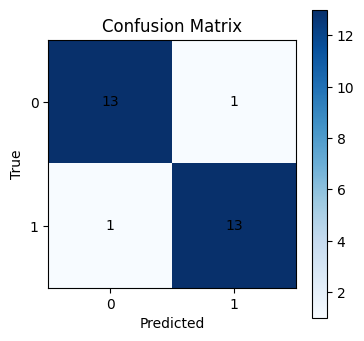

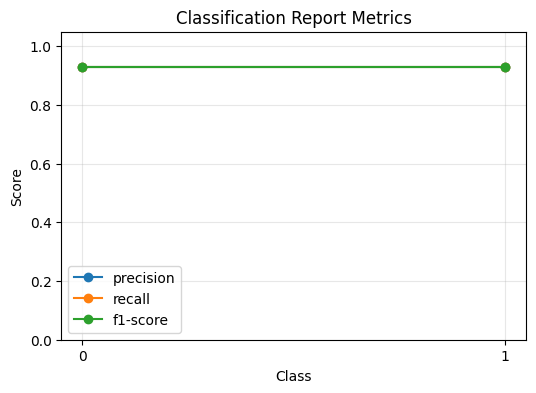

In [44]:
import matplotlib.pyplot as plt

results = []
for seq in seq_test:
    _, pred = classify(seq)
    results.append(pred)

cm = confusion_matrix(cat_test, results)

plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0, 1])
plt.yticks([0, 1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar()
plt.show()
report = classification_report(cat_test, results, output_dict=True)

labels = ["0", "1"]
metrics = ["precision", "recall", "f1-score"]

values = [[report[l][m] for l in labels] for m in metrics]

plt.figure(figsize=(6, 4))
for i, metric in enumerate(metrics):
    plt.plot(labels, values[i], marker="o", label=metric)

plt.title("Classification Report Metrics")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Save and Load Trained Model

In [47]:
torch.save(model.state_dict(), os.path.join("rnn_model","sequence_classifier.pth"))

model = SequenceClassifier(vocab_size)  # same architecture
model.load_state_dict(torch.load(os.path.join("rnn_model","sequence_classifier.pth")))
model.eval()

SequenceClassifier(
  (emb): Embedding(13, 16)
  (rnn): RNN(16, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)